<a href="https://colab.research.google.com/github/feer-rodriguess90/WiDS_Challenge2/blob/main/WIDS_2024_Challenge_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Step 1: Import the Libraries



In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import LabelBinarizer, OrdinalEncoder, RobustScaler
from sklearn.model_selection import train_test_split, KFold, GroupKFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor


import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow import feature_column

# Set seed for reproducibility
seed = 42

# Adjust the granularity of reporting - Display settings
pd.options.display.max_columns = None
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format


Step 2: Import Data and Perform Initial Analysis


In [4]:
train_df = pd.read_csv("/content/train.csv")
test_df = pd.read_csv("/content/test.csv")
train_df = train_df.reindex(np.random.permutation(train_df.index)) # Shuffle the training set
display(train_df.head(5))

,patient_id,patient_race,payer_type,patient_state,patient_zip3,Region,Division,patient_age,patient_gender,bmi,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,metastatic_cancer_diagnosis_code,metastatic_first_novel_treatment,metastatic_first_novel_treatment_type,population,density,age_median,age_under_10,age_10_to_19,age_20s,age_30s,age_40s,age_50s,age_60s,age_70s,age_over_80,male,female,married,divorced,never_married,widowed,family_size,family_dual_income,income_household_median,income_household_under_5,income_household_5_to_10,income_household_10_to_15,income_household_15_to_20,income_household_20_to_25,income_household_25_to_35,income_household_35_to_50,income_household_50_to_75,income_household_75_to_100,income_household_100_to_150,income_household_150_over,income_household_six_figure,income_individual_median,home_ownership,housing_units,home_value,rent_median,rent_burden,education_less_highschool,education_highschool,education_some_college,education_bachelors,education_graduate,education_college_or_above,education_stem_degree,labor_force_participation,unemployment_rate,self_employed,farmer,race_white,race_black,race_asian,race_native,race_pacific,race_other,race_multiple,hispanic,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Average of Jan-13,Average of Feb-13,Average of Mar-13,Average of Apr-13,Average of May-13,Average of Jun-13,Average of Jul-13,Average of Aug-13,Average of Sep-13,Average of Oct-13,Average of Nov-13,Average of Dec-13,Average of Jan-14,Average of Feb-14,Average of Mar-14,Average of Apr-14,Average of May-14,Average of Jun-14,Average of Jul-14,Average of Aug-14,Average of Sep-14,Average of Oct-14,Average of Nov-14,Average of Dec-14,Average of Jan-15,Average of Feb-15,Average of Mar-15,Average of Apr-15,Average of May-15,Average of Jun-15,Average of Jul-15,Average of Aug-15,Average of Sep-15,Average of Oct-15,Average of Nov-15,Average of Dec-15,Average of Jan-16,Average of Feb-16,Average of Mar-16,Average of Apr-16,Average of May-16,Average of Jun-16,Average of Jul-16,Average of Aug-16,Average of Sep-16,Average of Oct-16,Average of Nov-16,Average of Dec-16,Average of Jan-17,Average of Feb-17,Average of Mar-17,Average of Apr-17,Average of May-17,Average of Jun-17,Average of Jul-17,Average of Aug-17,Average of Sep-17,Average of Oct-17,Average of Nov-17,Average of Dec-17,Average of Jan-18,Average of Feb-18,Average of Mar-18,Average of Apr-18,Average of May-18,Average of Jun-18,Average of Jul-18,Average of Aug-18,Average of Sep-18,Average of Oct-18,Average of Nov-18,Average of Dec-18,metastatic_diagnosis_period
8239,814625,Hispanic,MEDICARE ADVANTAGE,FL,331,South,South Atlantic,67,F,NaN,C50911,Malignant neoplasm of unsp site of right femal...,C773,NaN,NaN,32045.8,3045.1,41.0,10.8,11.1,12.8,14.4,14.2,14.1,10.6,7.4,4.5,49.3,50.7,44.2,15.3,35.1,5.4,3.3,53.3,71422.2,3.6,3.5,4.6,4.2,4.5,8.9,11.2,15.8,11.7,14.2,17.6,31.9,33791.4,53.1,11516.0,405353.4,1646.5,41.0,15.0,23.2,23.2,22.7,15.9,38.6,43.7,63.5,5.0,22.2,0.1,59.1,15.3,1.9,0.2,0.0,4.7,18.9,63.8,9.2,14.2,21.2,31.1,14.0,2.3,72.4,70.5,66.2,76.7,77.7,82.2,82.0,83.3,82.2,79.9,76.6,74.5,66.7,73.2,72.1,76.2,79.6,80.8,83.4,84.6,82.4,79.0,71.7,70.0,69.8,66.5,75.8,79.6,79.8,82.9,84.1,84.1,83.2,80.4,79.1,77.4,66.9,66.7,74.8,76.6,79.5,83.4,84.7,83.9,83.1,79.6,73.8,75.6,69.9,72.4,72.0,76.8,80.5,82.6,84.7,84.3,83.5,79.6,75.3,70.0,66.3,75.0,69.6,76.5,78.8,82.7,83.7,83.8,83.2,81.5,76.3,71.0,0
6746,996909,NaN,COMMERCIAL,OH,444,Midwest,East North Central,58,F,NaN,C50912,Malignant neoplasm of unspecified site of left...,C773,NaN,NaN,6444.0,161.9,45.0,10.9,11.8,10.7,10.2,12.1,15.1,15.0,9.4,4.9,50.2,49.8,53.1,13.2,26.1,7.5,3.0,49.0,58111.5,2.6,2.9,3.7,5.0,4.7,11.8,13.2,19.2,13.7,15.5,7.7,23.2,30371.2,79.6,2665.1,129760.5,713.6,27.5,10.0,44.5,26.3,12.2,6.9,19.1,39.9,57.8,4.5,9.7,1.7,93.4,2.8,0.4,0.1,0.0,0.5,2.9,2.1,15.2,12.2,0.4,25.5,6.3,9.2,29.0,26.5,32.9,47.8,60.8,66.9,71.6,67.8,62.1,53.7,37.7,31.2,18.9,20.1,29.1,48.0,59.6,67.6,68.2,67.9,62.6,52.5

In [5]:
# Print the size of the data set

print("Numbers of rows and columns in training set: ", train_df.shape)
print("Numbers of rows and columns in testing set: ", test_df.shape)

Numbers of rows and columns in training set:  (13173, 152)
Numbers of rows and columns in testing set:  (5646, 151)


In [6]:
# Print column name and type of the training set

print(train_df.info())
print(train_df.dtypes)

<class 'pandas.core.frame.DataFrame'>
Index: 13173 entries, 8239 to 702
Columns: 152 entries, patient_id to metastatic_diagnosis_period
dtypes: float64(137), int64(4), object(11)
memory usage: 15.4+ MB
None
patient_id                       int64
patient_race                    object
payer_type                      object
patient_state                   object
patient_zip3                     int64
                                ...   
Average of Sep-18              float64
Average of Oct-18              float64
Average of Nov-18              float64
Average of Dec-18              float64
metastatic_diagnosis_period      int64
Length: 152, dtype: object


In [7]:
# Print out different data types

# Categorical columns
cat_col = [col for col in train_df.columns if train_df[col].dtype == 'object']
print('Categotical columns: ', cat_col)

# Numerical columns
num_col = [col for col in train_df.columns if train_df[col].dtype != 'object']
print('Numerical columns: ', num_col)

Categotical columns:  ['patient_race', 'payer_type', 'patient_state', 'Region', 'Division', 'patient_gender', 'breast_cancer_diagnosis_code', 'breast_cancer_diagnosis_desc', 'metastatic_cancer_diagnosis_code', 'metastatic_first_novel_treatment', 'metastatic_first_novel_treatment_type']
Numerical columns:  ['patient_id', 'patient_zip3', 'patient_age', 'bmi', 'population', 'density', 'age_median', 'age_under_10', 'age_10_to_19', 'age_20s', 'age_30s', 'age_40s', 'age_50s', 'age_60s', 'age_70s', 'age_over_80', 'male', 'female', 'married', 'divorced', 'never_married', 'widowed', 'family_size', 'family_dual_income', 'income_household_median', 'income_household_under_5', 'income_household_5_to_10', 'income_household_10_to_15', 'income_household_15_to_20', 'income_household_20_to_25', 'income_household_25_to_35', 'income_household_35_to_50', 'income_household_50_to_75', 'income_household_75_to_100', 'income_household_100_to_150', 'income_household_150_over', 'income_household_six_figure', 'inc

## Data Analysis

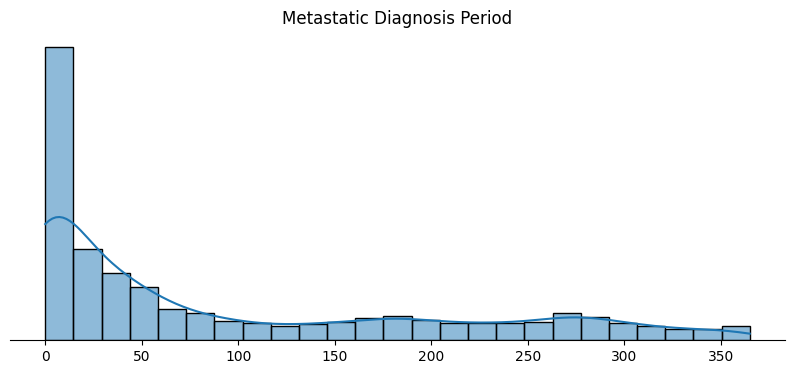

In [8]:
plt.figure(figsize=(10, 4))
sns.histplot(data=train_df, x='metastatic_diagnosis_period', kde=True)
plt.title('Metastatic Diagnosis Period')
plt.xlabel('')
plt.ylabel('')
plt.yticks([])
sns.despine(left=True, bottom=False)
plt.show()

In [9]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(rows=1, cols=2)
fig.add_trace(go.Bar(y=train_df["patient_race"].value_counts(), x=["White", "Black", "Hispanic", "Other", "Asian"], name="Race"), row=1, col=1)
fig.add_trace(go.Bar(y=train_df["payer_type"].value_counts(), x=["Commercial", "Medicaid", "Medicare"], name="Payer Type"), row=1, col=2)



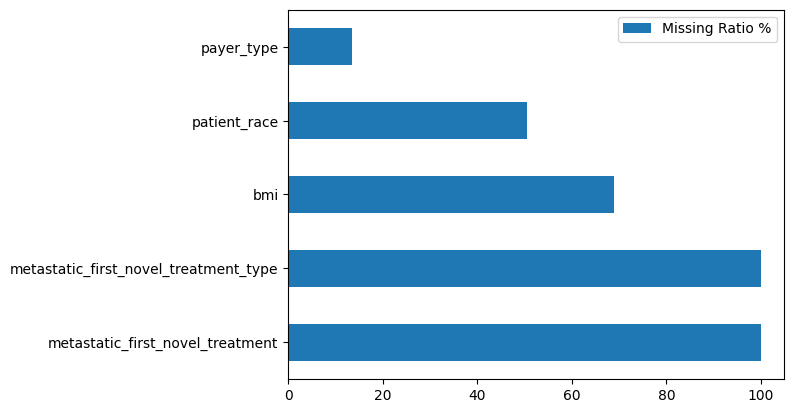

In [10]:
# Plot the columns that have the most missing values
def plot_nas(df: pd.DataFrame):
  if df.isnull().sum().sum() != 0:
    na_df = (df.isnull().sum() / len(df)) * 100
    na_df = na_df.drop(na_df[na_df == 0].index).sort_values(ascending=False)
    missing_data = pd.DataFrame({'Missing Ratio %': na_df})
    missing_data_more_than_20_percent = missing_data[missing_data['Missing Ratio %'] > 10.0]
    missing_data_more_than_20_percent.plot(kind = "barh")
    plt.show()
  else:
    print('No NAs found')

plot_nas(train_df)

* High number of null values. What draws the most attention is 'bmi' which contains 69% of null data.


<Axes: xlabel='payer_type'>

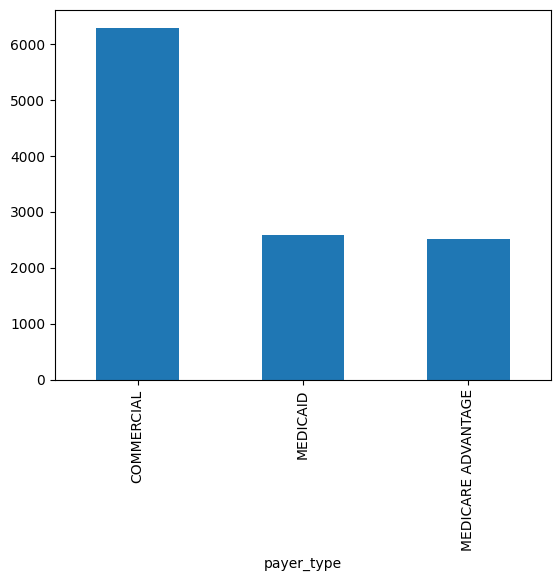

In [11]:
# Plot Categotical Columns

train_df['payer_type'].value_counts().plot(kind='bar')

In [12]:
# Print statistical summary of numerical columns

train_df['bmi'].describe()

count   4102.0
mean      29.2
std        5.8
min       15.0
25%       24.8
50%       28.6
75%       33.0
max       97.0
Name: bmi, dtype: float64

Text(0.5, 1.0, 'Correlation Between BMI and Race')

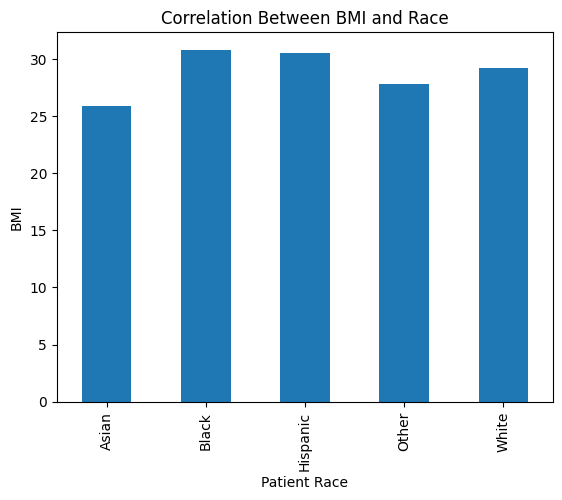

In [13]:
# Plot correlation between categorical values vs. numerical values

train_df.groupby(['patient_race'])["bmi"].mean().plot(kind='bar')
plt.xlabel('Patient Race')
plt.ylabel('BMI')
plt.title('Correlation Between BMI and Race')


<Axes: xlabel='patient_race'>

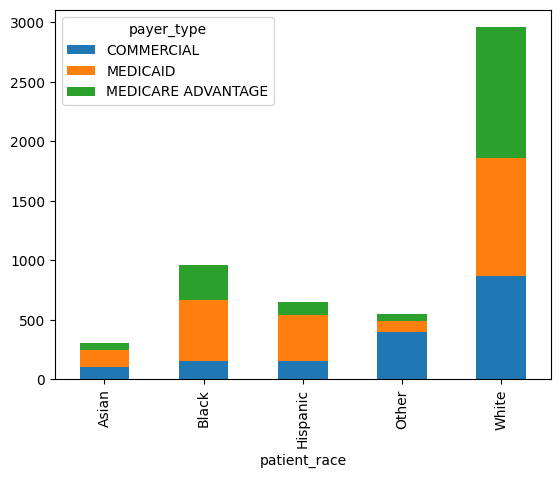

In [14]:
# Plot correlation between categorical values vs. categorical values

pd.crosstab(train_df['patient_race'], train_df['payer_type']).plot(kind="bar",stacked=True)

Step 3: Fundamental Data Cleaning Steps

Handle missing values


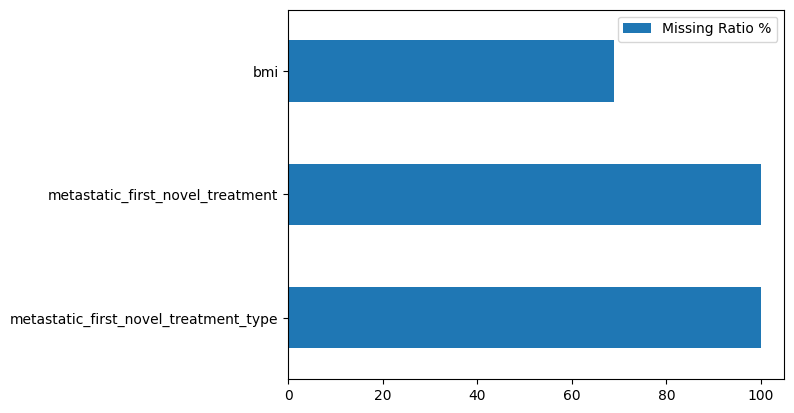

In [15]:
# Fill in empty value in the "patient_race" column with "N/A"
train_df["patient_race"].fillna("N/A", inplace=True)

# Fill in empty value in the "payer_type" column with "N/A"
train_df["payer_type"].fillna("N/A", inplace=True)

# Patient race and Payer type are not show anymore because already handle the missing value
plot_nas(train_df)

<Axes: ylabel='bmi'>

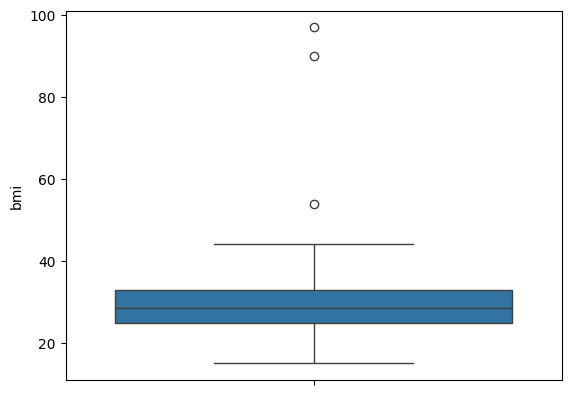

In [16]:
# Filter out data outliers

# Plot the BMI value to detect outliners
sns.boxplot(train_df['bmi'])

# outliner_train_df = train_df[train_df['bmi] > 70]
# display(outliner_train_df)

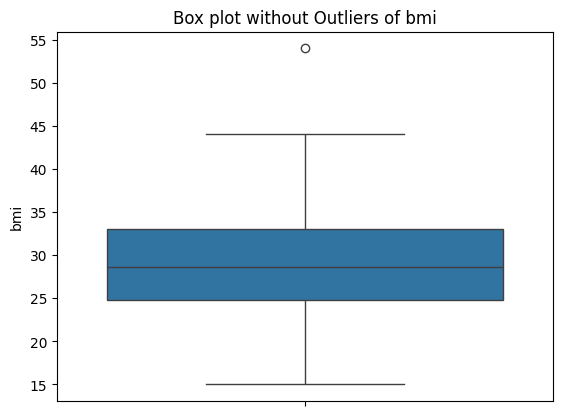

In [17]:
def removal_box_plot(df, column, threshold):
  removed_outliers = df[df[column] <= threshold]

  sns.boxplot(removed_outliers[column])
  plt.title(f'Box plot without Outliers of {column}')
  plt.show()
  return removed_outliers

threshold_value = 70
no_outilers = removal_box_plot(train_df, 'bmi', threshold_value)

Step 4: Data Transformation Techniques


In [18]:
# Label Encoding
le1 = preprocessing.LabelEncoder()
train_df['payer_type_label_encode'] = le1.fit_transform(train_df['payer_type'])
display(train_df)

,patient_id,patient_race,payer_type,patient_state,patient_zip3,Region,Division,patient_age,patient_gender,bmi,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,metastatic_cancer_diagnosis_code,metastatic_first_novel_treatment,metastatic_first_novel_treatment_type,population,density,age_median,age_under_10,age_10_to_19,age_20s,age_30s,age_40s,age_50s,age_60s,age_70s,age_over_80,male,female,married,divorced,never_married,widowed,family_size,family_dual_income,income_household_median,income_household_under_5,income_household_5_to_10,income_household_10_to_15,income_household_15_to_20,income_household_20_to_25,income_household_25_to_35,income_household_35_to_50,income_household_50_to_75,income_household_75_to_100,income_household_100_to_150,income_household_150_over,income_household_six_figure,income_individual_median,home_ownership,housing_units,home_value,rent_median,rent_burden,education_less_highschool,education_highschool,education_some_college,education_bachelors,education_graduate,education_college_or_above,education_stem_degree,labor_force_participation,unemployment_rate,self_employed,farmer,race_white,race_black,race_asian,race_native,race_pacific,race_other,race_multiple,hispanic,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Average of Jan-13,Average of Feb-13,Average of Mar-13,Average of Apr-13,Average of May-13,Average of Jun-13,Average of Jul-13,Average of Aug-13,Average of Sep-13,Average of Oct-13,Average of Nov-13,Average of Dec-13,Average of Jan-14,Average of Feb-14,Average of Mar-14,Average of Apr-14,Average of May-14,Average of Jun-14,Average of Jul-14,Average of Aug-14,Average of Sep-14,Average of Oct-14,Average of Nov-14,Average of Dec-14,Average of Jan-15,Average of Feb-15,Average of Mar-15,Average of Apr-15,Average of May-15,Average of Jun-15,Average of Jul-15,Average of Aug-15,Average of Sep-15,Average of Oct-15,Average of Nov-15,Average of Dec-15,Average of Jan-16,Average of Feb-16,Average of Mar-16,Average of Apr-16,Average of May-16,Average of Jun-16,Average of Jul-16,Average of Aug-16,Average of Sep-16,Average of Oct-16,Average of Nov-16,Average of Dec-16,Average of Jan-17,Average of Feb-17,Average of Mar-17,Average of Apr-17,Average of May-17,Average of Jun-17,Average of Jul-17,Average of Aug-17,Average of Sep-17,Average of Oct-17,Average of Nov-17,Average of Dec-17,Average of Jan-18,Average of Feb-18,Average of Mar-18,Average of Apr-18,Average of May-18,Average of Jun-18,Average of Jul-18,Average of Aug-18,Average of Sep-18,Average of Oct-18,Average of Nov-18,Average of Dec-18,metastatic_diagnosis_period,payer_type_label_encode
8239,814625,Hispanic,MEDICARE ADVANTAGE,FL,331,South,South Atlantic,67,F,NaN,C50911,Malignant neoplasm of unsp site of right femal...,C773,NaN,NaN,32045.8,3045.1,41.0,10.8,11.1,12.8,14.4,14.2,14.1,10.6,7.4,4.5,49.3,50.7,44.2,15.3,35.1,5.4,3.3,53.3,71422.2,3.6,3.5,4.6,4.2,4.5,8.9,11.2,15.8,11.7,14.2,17.6,31.9,33791.4,53.1,11516.0,405353.4,1646.5,41.0,15.0,23.2,23.2,22.7,15.9,38.6,43.7,63.5,5.0,22.2,0.1,59.1,15.3,1.9,0.2,0.0,4.7,18.9,63.8,9.2,14.2,21.2,31.1,14.0,2.3,72.4,70.5,66.2,76.7,77.7,82.2,82.0,83.3,82.2,79.9,76.6,74.5,66.7,73.2,72.1,76.2,79.6,80.8,83.4,84.6,82.4,79.0,71.7,70.0,69.8,66.5,75.8,79.6,79.8,82.9,84.1,84.1,83.2,80.4,79.1,77.4,66.9,66.7,74.8,76.6,79.5,83.4,84.7,83.9,83.1,79.6,73.8,75.6,69.9,72.4,72.0,76.8,80.5,82.6,84.7,84.3,83.5,79.6,75.3,70.0,66.3,75.0,69.6,76.5,78.8,82.7,83.7,83.8,83.2,81.5,76.3,71.0,0,2
6746,996909,N/A,COMMERCIAL,OH,444,Midwest,East North Central,58,F,NaN,C50912,Malignant neoplasm of unspecified site of left...,C773,NaN,NaN,6444.0,161.9,45.0,10.9,11.8,10.7,10.2,12.1,15.1,15.0,9.4,4.9,50.2,49.8,53.1,13.2,26.1,7.5,3.0,49.0,58111.5,2.6,2.9,3.7,5.0,4.7,11.8,13.2,19.2,13.7,15.5,7.7,23.2,30371.2,79.6,2665.1,129760.5,713.6,27.5,10.0,44.5,26.3,12.2,6.9,19.1,39.9,57.8,4.5,9.7,1.7,93.4,2.8,0.4,0.1,0.0,0.5,2.9,2.1,15.2,12.2,0.4,25.5,6.3,9.2,29.0,26.5,32.9,47.8,60.8,66.9,71.6,67.8,62.1,53.7,37.7,31.2,18.9,20.1,29.1,48.0,59.

In [19]:
# One-hot Encoding - Generate 4 different columns based on what categories
# Get the categorical values
one_hot_enconder = LabelBinarizer()
one_hot_enconder.fit(train_df['payer_type'])
print(one_hot_enconder.classes_)

# Transform our payer_type column to 4 different binary columns corresponding to different categories
transformed = pd.DataFrame(one_hot_enconder.transform(train_df['payer_type']),columns=one_hot_enconder.classes_)
# Combine with original data frame
train_df  = pd.concat([train_df, transformed], axis=1)
display(train_df)

['COMMERCIAL' 'MEDICAID' 'MEDICARE ADVANTAGE' 'N/A']


,patient_id,patient_race,payer_type,patient_state,patient_zip3,Region,Division,patient_age,patient_gender,bmi,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,metastatic_cancer_diagnosis_code,metastatic_first_novel_treatment,metastatic_first_novel_treatment_type,population,density,age_median,age_under_10,age_10_to_19,age_20s,age_30s,age_40s,age_50s,age_60s,age_70s,age_over_80,male,female,married,divorced,never_married,widowed,family_size,family_dual_income,income_household_median,income_household_under_5,income_household_5_to_10,income_household_10_to_15,income_household_15_to_20,income_household_20_to_25,income_household_25_to_35,income_household_35_to_50,income_household_50_to_75,income_household_75_to_100,income_household_100_to_150,income_household_150_over,income_household_six_figure,income_individual_median,home_ownership,housing_units,home_value,rent_median,rent_burden,education_less_highschool,education_highschool,education_some_college,education_bachelors,education_graduate,education_college_or_above,education_stem_degree,labor_force_participation,unemployment_rate,self_employed,farmer,race_white,race_black,race_asian,race_native,race_pacific,race_other,race_multiple,hispanic,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Average of Jan-13,Average of Feb-13,Average of Mar-13,Average of Apr-13,Average of May-13,Average of Jun-13,Average of Jul-13,Average of Aug-13,Average of Sep-13,Average of Oct-13,Average of Nov-13,Average of Dec-13,Average of Jan-14,Average of Feb-14,Average of Mar-14,Average of Apr-14,Average of May-14,Average of Jun-14,Average of Jul-14,Average of Aug-14,Average of Sep-14,Average of Oct-14,Average of Nov-14,Average of Dec-14,Average of Jan-15,Average of Feb-15,Average of Mar-15,Average of Apr-15,Average of May-15,Average of Jun-15,Average of Jul-15,Average of Aug-15,Average of Sep-15,Average of Oct-15,Average of Nov-15,Average of Dec-15,Average of Jan-16,Average of Feb-16,Average of Mar-16,Average of Apr-16,Average of May-16,Average of Jun-16,Average of Jul-16,Average of Aug-16,Average of Sep-16,Average of Oct-16,Average of Nov-16,Average of Dec-16,Average of Jan-17,Average of Feb-17,Average of Mar-17,Average of Apr-17,Average of May-17,Average of Jun-17,Average of Jul-17,Average of Aug-17,Average of Sep-17,Average of Oct-17,Average of Nov-17,Average of Dec-17,Average of Jan-18,Average of Feb-18,Average of Mar-18,Average of Apr-18,Average of May-18,Average of Jun-18,Average of Jul-18,Average of Aug-18,Average of Sep-18,Average of Oct-18,Average of Nov-18,Average of Dec-18,metastatic_diagnosis_period,payer_type_label_encode,COMMERCIAL,MEDICAID,MEDICARE ADVANTAGE,N/A
8239,814625,Hispanic,MEDICARE ADVANTAGE,FL,331,South,South Atlantic,67,F,NaN,C50911,Malignant neoplasm of unsp site of right femal...,C773,NaN,NaN,32045.8,3045.1,41.0,10.8,11.1,12.8,14.4,14.2,14.1,10.6,7.4,4.5,49.3,50.7,44.2,15.3,35.1,5.4,3.3,53.3,71422.2,3.6,3.5,4.6,4.2,4.5,8.9,11.2,15.8,11.7,14.2,17.6,31.9,33791.4,53.1,11516.0,405353.4,1646.5,41.0,15.0,23.2,23.2,22.7,15.9,38.6,43.7,63.5,5.0,22.2,0.1,59.1,15.3,1.9,0.2,0.0,4.7,18.9,63.8,9.2,14.2,21.2,31.1,14.0,2.3,72.4,70.5,66.2,76.7,77.7,82.2,82.0,83.3,82.2,79.9,76.6,74.5,66.7,73.2,72.1,76.2,79.6,80.8,83.4,84.6,82.4,79.0,71.7,70.0,69.8,66.5,75.8,79.6,79.8,82.9,84.1,84.1,83.2,80.4,79.1,77.4,66.9,66.7,74.8,76.6,79.5,83.4,84.7,83.9,83.1,79.6,73.8,75.6,69.9,72.4,72.0,76.8,80.5,82.6,84.7,84.3,83.5,79.6,75.3,70.0,66.3,75.0,69.6,76.5,78.8,82.7,83.7,83.8,83.2,81.5,76.3,71.0,0,2,1,0,0,0
6746,996909,N/A,COMMERCIAL,OH,444,Midwest,East North Central,58,F,NaN,C50912,Malignant neoplasm of unspecified site of left...,C773,NaN,NaN,6444.0,161.9,45.0,10.9,11.8,10.7,10.2,12.1,15.1,15.0,9.4,4.9,50.2,49.8,53.1,13.2,26.1,7.5,3.0,49.0,58111.5,2.6,2.9,3.7,5.0,4.7,11.8,13.2,19.2,13.7,15.5,7.7,23.2,30371.2,79.6,2665.1,129760.5,713.6,27.5,10.0,44.5,26.3,12.2,6.9,19.1,39.9,57.8,4.5,9.7,1.7,93.4,2.8,0.4,0.1,0.0,0.5,2.9,2.1,15.2,12.2,0.4,25.5,6.3,9.2,29.0,26.5,32.9,47.8,60.8,66.9,71

In [20]:
# Bucketized columns - Split its value into different categories based on numerical ranges
# Instead of representing age as a numeric column, we could split the age into several buckets

bins = [0,2,4,13,20,70,100]
labels = ['Infant','Toddler','Kid','Teen','Adult','Old Adult']
train_df['patient_age_group'] = pd.cut(train_df['patient_age'], bins=bins, labels=labels, right=False)
display (train_df)

,patient_id,patient_race,payer_type,patient_state,patient_zip3,Region,Division,patient_age,patient_gender,bmi,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,metastatic_cancer_diagnosis_code,metastatic_first_novel_treatment,metastatic_first_novel_treatment_type,population,density,age_median,age_under_10,age_10_to_19,age_20s,age_30s,age_40s,age_50s,age_60s,age_70s,age_over_80,male,female,married,divorced,never_married,widowed,family_size,family_dual_income,income_household_median,income_household_under_5,income_household_5_to_10,income_household_10_to_15,income_household_15_to_20,income_household_20_to_25,income_household_25_to_35,income_household_35_to_50,income_household_50_to_75,income_household_75_to_100,income_household_100_to_150,income_household_150_over,income_household_six_figure,income_individual_median,home_ownership,housing_units,home_value,rent_median,rent_burden,education_less_highschool,education_highschool,education_some_college,education_bachelors,education_graduate,education_college_or_above,education_stem_degree,labor_force_participation,unemployment_rate,self_employed,farmer,race_white,race_black,race_asian,race_native,race_pacific,race_other,race_multiple,hispanic,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Average of Jan-13,Average of Feb-13,Average of Mar-13,Average of Apr-13,Average of May-13,Average of Jun-13,Average of Jul-13,Average of Aug-13,Average of Sep-13,Average of Oct-13,Average of Nov-13,Average of Dec-13,Average of Jan-14,Average of Feb-14,Average of Mar-14,Average of Apr-14,Average of May-14,Average of Jun-14,Average of Jul-14,Average of Aug-14,Average of Sep-14,Average of Oct-14,Average of Nov-14,Average of Dec-14,Average of Jan-15,Average of Feb-15,Average of Mar-15,Average of Apr-15,Average of May-15,Average of Jun-15,Average of Jul-15,Average of Aug-15,Average of Sep-15,Average of Oct-15,Average of Nov-15,Average of Dec-15,Average of Jan-16,Average of Feb-16,Average of Mar-16,Average of Apr-16,Average of May-16,Average of Jun-16,Average of Jul-16,Average of Aug-16,Average of Sep-16,Average of Oct-16,Average of Nov-16,Average of Dec-16,Average of Jan-17,Average of Feb-17,Average of Mar-17,Average of Apr-17,Average of May-17,Average of Jun-17,Average of Jul-17,Average of Aug-17,Average of Sep-17,Average of Oct-17,Average of Nov-17,Average of Dec-17,Average of Jan-18,Average of Feb-18,Average of Mar-18,Average of Apr-18,Average of May-18,Average of Jun-18,Average of Jul-18,Average of Aug-18,Average of Sep-18,Average of Oct-18,Average of Nov-18,Average of Dec-18,metastatic_diagnosis_period,payer_type_label_encode,COMMERCIAL,MEDICAID,MEDICARE ADVANTAGE,N/A,patient_age_group
8239,814625,Hispanic,MEDICARE ADVANTAGE,FL,331,South,South Atlantic,67,F,NaN,C50911,Malignant neoplasm of unsp site of right femal...,C773,NaN,NaN,32045.8,3045.1,41.0,10.8,11.1,12.8,14.4,14.2,14.1,10.6,7.4,4.5,49.3,50.7,44.2,15.3,35.1,5.4,3.3,53.3,71422.2,3.6,3.5,4.6,4.2,4.5,8.9,11.2,15.8,11.7,14.2,17.6,31.9,33791.4,53.1,11516.0,405353.4,1646.5,41.0,15.0,23.2,23.2,22.7,15.9,38.6,43.7,63.5,5.0,22.2,0.1,59.1,15.3,1.9,0.2,0.0,4.7,18.9,63.8,9.2,14.2,21.2,31.1,14.0,2.3,72.4,70.5,66.2,76.7,77.7,82.2,82.0,83.3,82.2,79.9,76.6,74.5,66.7,73.2,72.1,76.2,79.6,80.8,83.4,84.6,82.4,79.0,71.7,70.0,69.8,66.5,75.8,79.6,79.8,82.9,84.1,84.1,83.2,80.4,79.1,77.4,66.9,66.7,74.8,76.6,79.5,83.4,84.7,83.9,83.1,79.6,73.8,75.6,69.9,72.4,72.0,76.8,80.5,82.6,84.7,84.3,83.5,79.6,75.3,70.0,66.3,75.0,69.6,76.5,78.8,82.7,83.7,83.8,83.2,81.5,76.3,71.0,0,2,1,0,0,0,Adult
6746,996909,N/A,COMMERCIAL,OH,444,Midwest,East North Central,58,F,NaN,C50912,Malignant neoplasm of unspecified site of left...,C773,NaN,NaN,6444.0,161.9,45.0,10.9,11.8,10.7,10.2,12.1,15.1,15.0,9.4,4.9,50.2,49.8,53.1,13.2,26.1,7.5,3.0,49.0,58111.5,2.6,2.9,3.7,5.0,4.7,11.8,13.2,19.2,13.7,15.5,7.7,23.2,30371.2,79.6,2665.1,129760.5,713.6,27.5,10.0,44.5,26.3,12.2,6.9,19.1,39.9,57.8,4.5,9.7,1.7,93.4,2.8,0.4,0.1,0.0,0.5,2.9,2.1,15.2,12.2,0.4,25.5,6.3,9.2,29.0,26.

In [21]:
# Scaling

display(train_df["home_value"])

8239    405353.4
6746    129760.5
8857    237098.5
2944    146144.8
5623    610404.0
          ...   
12005   602986.8
10000   354234.3
8960    146044.8
4241    280274.1
702     142343.6
Name: home_value, Length: 13173, dtype: float64

In [22]:
# Min-Max Scaling (normalization)

def min_max_scaling(df, column_name):
  min_value = df[column_name].min()
  max_value = df[column_name].max()
  df[column_name] = (df[column_name] - min_value) / (max_value - min_value)

# Apply min-max scaling to 'Salary' column
min_max_scaling(train_df, 'home_value')

# Print the DataFrame after min-max scaling
print("DataFrame after Min-Max Scaling:")
display(train_df["home_value"])

DataFrame after Min-Max Scaling:


8239    0.2
6746    0.0
8857    0.1
2944    0.0
5623    0.3
         ..
12005   0.3
10000   0.2
8960    0.0
4241    0.1
702     0.0
Name: home_value, Length: 13173, dtype: float64

# 🛠 Feature Selection

In [29]:
# Dependent variable 'metastatic_diagnosis_period'

X = train_df.drop(['patient_id', 'patient_race', 'bmi', 'breast_cancer_diagnosis_desc', 'metastatic_diagnosis_period', 'patient_age_group'], axis=1)
y = train_df['metastatic_diagnosis_period']

print(X.shape, y.shape)
X.head()

(13173, 152) (13173,)


,payer_type,patient_state,patient_zip3,Region,Division,patient_age,patient_gender,breast_cancer_diagnosis_code,metastatic_cancer_diagnosis_code,metastatic_first_novel_treatment,metastatic_first_novel_treatment_type,population,density,age_median,age_under_10,age_10_to_19,age_20s,age_30s,age_40s,age_50s,age_60s,age_70s,age_over_80,male,female,married,divorced,never_married,widowed,family_size,family_dual_income,income_household_median,income_household_under_5,income_household_5_to_10,income_household_10_to_15,income_household_15_to_20,income_household_20_to_25,income_household_25_to_35,income_household_35_to_50,income_household_50_to_75,income_household_75_to_100,income_household_100_to_150,income_household_150_over,income_household_six_figure,income_individual_median,home_ownership,housing_units,home_value,rent_median,rent_burden,education_less_highschool,education_highschool,education_some_college,education_bachelors,education_graduate,education_college_or_above,education_stem_degree,labor_force_participation,unemployment_rate,self_employed,farmer,race_white,race_black,race_asian,race_native,race_pacific,race_other,race_multiple,hispanic,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Average of Jan-13,Average of Feb-13,Average of Mar-13,Average of Apr-13,Average of May-13,Average of Jun-13,Average of Jul-13,Average of Aug-13,Average of Sep-13,Average of Oct-13,Average of Nov-13,Average of Dec-13,Average of Jan-14,Average of Feb-14,Average of Mar-14,Average of Apr-14,Average of May-14,Average of Jun-14,Average of Jul-14,Average of Aug-14,Average of Sep-14,Average of Oct-14,Average of Nov-14,Average of Dec-14,Average of Jan-15,Average of Feb-15,Average of Mar-15,Average of Apr-15,Average of May-15,Average of Jun-15,Average of Jul-15,Average of Aug-15,Average of Sep-15,Average of Oct-15,Average of Nov-15,Average of Dec-15,Average of Jan-16,Average of Feb-16,Average of Mar-16,Average of Apr-16,Average of May-16,Average of Jun-16,Average of Jul-16,Average of Aug-16,Average of Sep-16,Average of Oct-16,Average of Nov-16,Average of Dec-16,Average of Jan-17,Average of Feb-17,Average of Mar-17,Average of Apr-17,Average of May-17,Average of Jun-17,Average of Jul-17,Average of Aug-17,Average of Sep-17,Average of Oct-17,Average of Nov-17,Average of Dec-17,Average of Jan-18,Average of Feb-18,Average of Mar-18,Average of Apr-18,Average of May-18,Average of Jun-18,Average of Jul-18,Average of Aug-18,Average of Sep-18,Average of Oct-18,Average of Nov-18,Average of Dec-18,payer_type_label_encode,COMMERCIAL,MEDICAID,MEDICARE ADVANTAGE,N/A
8239,MEDICARE ADVANTAGE,FL,331,South,South Atlantic,67,F,C50911,C773,NaN,NaN,32045.8,3045.1,41.0,10.8,11.1,12.8,14.4,14.2,14.1,10.6,7.4,4.5,49.3,50.7,44.2,15.3,35.1,5.4,3.3,53.3,71422.2,3.6,3.5,4.6,4.2,4.5,8.9,11.2,15.8,11.7,14.2,17.6,31.9,33791.4,53.1,11516.0,0.2,1646.5,41.0,15.0,23.2,23.2,22.7,15.9,38.6,43.7,63.5,5.0,22.2,0.1,59.1,15.3,1.9,0.2,0.0,4.7,18.9,63.8,9.2,14.2,21.2,31.1,14.0,2.3,72.4,70.5,66.2,76.7,77.7,82.2,82.0,83.3,82.2,79.9,76.6,74.5,66.7,73.2,72.1,76.2,79.6,80.8,83.4,84.6,82.4,79.0,71.7,70.0,69.8,66.5,75.8,79.6,79.8,82.9,84.1,84.1,83.2,80.4,79.1,77.4,66.9,66.7,74.8,76.6,79.5,83.4,84.7,83.9,83.1,79.6,73.8,75.6,69.9,72.4,72.0,76.8,80.5,82.6,84.7,84.3,83.5,79.6,75.3,70.0,66.3,75.0,69.6,76.5,78.8,82.7,83.7,83.8,83.2,81.5,76.3,71.0,2,1,0,0,0
6746,COMMERCIAL,OH,444,Midwest,East North Central,58,F,C50912,C773,NaN,NaN,6444.0,161.9,45.0,10.9,11.8,10.7,10.2,12.1,15.1,15.0,9.4,4.9,50.2,49.8,53.1,13.2,26.1,7.5,3.0,49.0,58111.5,2.6,2.9,3.7,5.0,4.7,11.8,13.2,19.2,13.7,15.5,7.7,23.2,30371.2,79.6,2665.1,0.0,713.6,27.5,10.0,44.5,26.3,12.2,6.9,19.1,39.9,57.8,4.5,9.7,1.7,93.4,2.8,0.4,0.1,0.0,0.5,2.9,2.1,15.2,12.2,0.4,25.5,6.3,9.2,29.0,26.5,32.9,47.8,60.8,66.9,71.6,67.8,62.1,53.7,37.7,31.2,18.9,20.1,29.1,48.0,59.6,67.6,68.2,67.9,62.6,52.5,36.4,34.8,21.9,12.7,31.1,48.1,63.1,67.1,70.1,68.6,67.5,51.8,46.7,42.7,25.8,31.1,43.1,47.3,59.2,68.1,72.5,74.3,67.2,55.0,43.9,30.1,32.6,37.0,36.9,53.1,61.8

# Check missing Values

In [28]:
print(X.columns)

Index(['payer_type', 'patient_state', 'patient_zip3', 'Region', 'Division',
       'patient_age', 'patient_gender', 'breast_cancer_diagnosis_code',
       'metastatic_cancer_diagnosis_code', 'metastatic_first_novel_treatment',
       ...
       'Average of Aug-18', 'Average of Sep-18', 'Average of Oct-18',
       'Average of Nov-18', 'Average of Dec-18', 'payer_type_label_encode',
       'COMMERCIAL', 'MEDICAID', 'MEDICARE ADVANTAGE', 'N/A'],
      dtype='object', length=152)


In [26]:
pd.options.display.max_rows = None
X.isna().any()

payer_type                               False
patient_state                            False
patient_zip3                             False
Region                                   False
Division                                 False
patient_age                              False
patient_gender                           False
breast_cancer_diagnosis_code             False
metastatic_cancer_diagnosis_code         False
metastatic_first_novel_treatment          True
metastatic_first_novel_treatment_type     True
population                               False
density                                  False
age_median                               False
age_under_10                             False
age_10_to_19                             False
age_20s                                  False
age_30s                                  False
age_40s                                  False
age_50s                                  False
age_60s                                  False
age_70s      

In [27]:
y.isna().any()

False

In [ ]:
# Encodes categorical features
# Splits data in training (80%) and testing (20%)

cols_categorical = X.columns[X.dtypes == 'object'].to_list()
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1).fit(X[cols_categorical])
X_enc = pd.concat([
    X[X.columns[~X.columns.isin(cols_categorical)]],
    pd.DataFrame(encoder.transform(X[cols_categorical]), columns=cols_categorical)], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_enc, y, random_state=seed, stratify=y, test_size=.2)
print('Training size: ', X_train.shape)
print('Testing size: ', X_test.shape)

X_train.head(2)

Training size:  (10538, 152)
Testing size:  (2635, 152)


,patient_zip3,patient_age,population,density,age_median,age_under_10,age_10_to_19,age_20s,age_30s,age_40s,age_50s,age_60s,age_70s,age_over_80,male,female,married,divorced,never_married,widowed,family_size,family_dual_income,income_household_median,income_household_under_5,income_household_5_to_10,income_household_10_to_15,income_household_15_to_20,income_household_20_to_25,income_household_25_to_35,income_household_35_to_50,income_household_50_to_75,income_household_75_to_100,income_household_100_to_150,income_household_150_over,income_household_six_figure,income_individual_median,home_ownership,housing_units,home_value,rent_median,rent_burden,education_less_highschool,education_highschool,education_some_college,education_bachelors,education_graduate,education_college_or_above,education_stem_degree,labor_force_participation,unemployment_rate,self_employed,farmer,race_white,race_black,race_asian,race_native,race_pacific,race_other,race_multiple,hispanic,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Average of Jan-13,Average of Feb-13,Average of Mar-13,Average of Apr-13,Average of May-13,Average of Jun-13,Average of Jul-13,Average of Aug-13,Average of Sep-13,Average of Oct-13,Average of Nov-13,Average of Dec-13,Average of Jan-14,Average of Feb-14,Average of Mar-14,Average of Apr-14,Average of May-14,Average of Jun-14,Average of Jul-14,Average of Aug-14,Average of Sep-14,Average of Oct-14,Average of Nov-14,Average of Dec-14,Average of Jan-15,Average of Feb-15,Average of Mar-15,Average of Apr-15,Average of May-15,Average of Jun-15,Average of Jul-15,Average of Aug-15,Average of Sep-15,Average of Oct-15,Average of Nov-15,Average of Dec-15,Average of Jan-16,Average of Feb-16,Average of Mar-16,Average of Apr-16,Average of May-16,Average of Jun-16,Average of Jul-16,Average of Aug-16,Average of Sep-16,Average of Oct-16,Average of Nov-16,Average of Dec-16,Average of Jan-17,Average of Feb-17,Average of Mar-17,Average of Apr-17,Average of May-17,Average of Jun-17,Average of Jul-17,Average of Aug-17,Average of Sep-17,Average of Oct-17,Average of Nov-17,Average of Dec-17,Average of Jan-18,Average of Feb-18,Average of Mar-18,Average of Apr-18,Average of May-18,Average of Jun-18,Average of Jul-18,Average of Aug-18,Average of Sep-18,Average of Oct-18,Average of Nov-18,Average of Dec-18,payer_type_label_encode,COMMERCIAL,MEDICAID,MEDICARE ADVANTAGE,N/A,payer_type,patient_state,Region,Division,patient_gender,breast_cancer_diagnosis_code,metastatic_cancer_diagnosis_code,metastatic_first_novel_treatment,metastatic_first_novel_treatment_type
11276,550,65,10310.8,169.8,40.8,12.2,13.5,10.9,12.8,12.4,15.2,12.7,6.7,3.5,51.0,49.0,55.8,11.2,28.6,4.4,3.1,60.6,87877.0,1.6,1.0,2.4,2.5,2.5,6.6,9.6,17.6,14.6,22.9,18.8,41.6,41615.9,85.3,3806.1,0.1,1164.5,28.4,6.1,30.9,35.6,19.0,8.4,27.4,42.1,68.0,4.4,11.5,3.6,90.3,2.0,1.6,0.7,0.0,1.4,4.0,4.3,11.1,6.4,0.7,29.1,4.3,7.7,14.7,15.6,23.4,37.6,55.0,65.8,71.2,70.3,64.4,47.4,30.6,10.2,4.3,4.8,21.3,40.4,56.1,67.4,69.0,70.2,60.3,47.1,24.2,23.3,15.8,8.3,31.5,46.9,56.1,66.5,70.9,67.9,66.1,49.7,40.2,29.3,14.6,21.9,38.5,45.7,57.5,67.9,71.8,70.6,63.5,50.9,42.1,18.9,18.1,27.4,30.8,47.0,55.5,67.2,71.4,65.9,64.0,49.7,30.9,17.2,12.3,11.4,29.5,33.8,64.2,69.5,71.8,70.3,63.0,43.4,26.3,23.9,0,0,0,1,0,2.0,19.0,0.0,0.0,0.0,45.0,39.0,NaN,NaN
8069,406,61,51377.0,91.2,40.7,11.0,13.0,12.6,12.5,12.4,14.1,13.2,7.6,3.4,48.1,51.9,46.4,16.3,31.0,6.3,2.8,47.2,59667.0,1.9,2.4,3.7,5.3,3.8,9.2,15.2,18.8,16.2,15.2,8.4,23.6,33913.0,62.7,22318.0,0.1,834.0,23.4,9.2,30.7,30.7,17.6,11.8,29.4,44.4,61.7,4.8,5.0,1.1,81.9,9.5,1.8,0.1,0.0,2.2,4.5,3.8,17.4,13.1,1.9,19.1,6.5,7.0,35.4,35.5,38.4,54.1,65.5,74.1,75.1,74.9,69.9,57.2,41.8,37.1,24.6,31.6,40.5,56.8,66.3,75.1,72.8,75.7,68.8,57.6,38.5,39.4,30.7,25.0,42.7,57.0,67.9,74.3,77.1,73.2,71.3,58.2,49.7,48.6,30.6,38.0,50.5,57.1,62.8,75.5,78.5,78.8,73.2,62.7,49.5,36.3,39.9,44.8,47.5,61.2,65.4,72.4,77.1,73.9,68.9,60.5,46.0,35.6,28.3,42.9,43.1,50.1,72.3,76.3,77.9,76.9,74.9,59.8,43.3,40.6,0,0,0

# Dealing with unbalanced data

In [ ]:
#y_train.value_counts()

metastatic_diagnosis_period
0      2501
28      112
14      112
21      107
7       103
       ... 
320       5
341       5
334       4
137       4
333       4
Name: count, Length: 366, dtype: int64

In [ ]:
# from imblearn.over_sampling import RandomOverSampler

# ros = RandomOverSampler(random_state=0)
# X_resample, y_resampled = ros.fit_resample(X_train, y_train)

In [ ]:
#y_resampled.value_counts()

metastatic_diagnosis_period
11     2501
306    2501
164    2501
110    2501
114    2501
       ... 
142    2501
50     2501
27     2501
100    2501
88     2501
Name: count, Length: 366, dtype: int64

# Training

In [ ]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report

# Instantiate the model
clf = HistGradientBoostingClassifier(random_state=42)

# Train the model - clf contains the model
clf.fit(X_train, y_train)

HistGradientBoostingClassifier(random_state=42)

In [ ]:
# Make predictions
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.07476280834914611
